In [1]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

from tqdm.auto import tqdm

import torchvision
import torchvision.models.detection as detection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
    transform = [transforms.ToTensor()]
    return transforms.Compose(transform)



In [37]:
class Kitti(torchvision.datasets.Kitti):
    def __getitem__(self, index):
        
        image, target = super().__getitem__(index)
        # Adding +1 to all indices to reserve 0 for background
        labels = [1 + ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare'].index(t['type']) for t in target if t['type'] in ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']]
        boxes = [t['bbox'] for t in target if t['type'] in ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']]
        
        target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4),
                  'labels': torch.as_tensor(labels, dtype=torch.int64)}
        return image, target


dataset = Kitti(root='../data')
dataset_test = Kitti(root='../data', transform=get_transform(train=False))

dataset[0]
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

In [38]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)
  return model

In [39]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Define the list of classes
class_list = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

num_classes = len(class_list) # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

In [40]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [41]:
dataset[0][0].shape

torch.Size([3, 376, 1241])

In [42]:
dataset[0][0]

tensor([[[0.2196, 0.2196, 0.2039,  ..., 0.0431, 0.0431, 0.0471],
         [0.2196, 0.2196, 0.2157,  ..., 0.0471, 0.0471, 0.0431],
         [0.2196, 0.2235, 0.2157,  ..., 0.0510, 0.0549, 0.0549],
         ...,
         [0.2902, 0.2588, 0.2549,  ..., 0.1176, 0.1255, 0.1294],
         [0.2353, 0.2706, 0.2784,  ..., 0.1059, 0.1176, 0.1216],
         [0.2392, 0.2980, 0.3373,  ..., 0.1059, 0.1176, 0.1216]],

        [[0.3333, 0.3255, 0.3176,  ..., 0.0588, 0.0510, 0.0471],
         [0.3294, 0.3216, 0.3137,  ..., 0.0745, 0.0588, 0.0510],
         [0.3176, 0.3216, 0.3176,  ..., 0.0745, 0.0667, 0.0588],
         ...,
         [0.4157, 0.2824, 0.2510,  ..., 0.1647, 0.1725, 0.1647],
         [0.3529, 0.2157, 0.2549,  ..., 0.1373, 0.1451, 0.1569],
         [0.1686, 0.2392, 0.3176,  ..., 0.1176, 0.1294, 0.1451]],

        [[0.4157, 0.4314, 0.4353,  ..., 0.0745, 0.0549, 0.0471],
         [0.4118, 0.4314, 0.4431,  ..., 0.0667, 0.0588, 0.0588],
         [0.4000, 0.4275, 0.4549,  ..., 0.0627, 0.0627, 0.

In [43]:
dataset[0][0].unsqueeze(0).shape

torch.Size([1, 3, 376, 1241])

In [44]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation during inference
with torch.no_grad():
    predictions = model(dataset[0][0].unsqueeze(0))

# Now you can use `predictions` for further processing



In [45]:
print(predictions)

[{'boxes': tensor([[3.8339e+02, 1.4986e+02, 4.6511e+02, 1.9354e+02],
        [4.0612e+02, 1.1888e+02, 4.8718e+02, 1.6378e+02],
        [4.1211e+02, 1.3267e+02, 4.9258e+02, 1.7707e+02],
        [3.8241e+02, 1.1118e+02, 4.6377e+02, 1.5538e+02],
        [4.8195e+02, 1.2689e+02, 5.0308e+02, 1.7296e+02],
        [4.4311e+02, 1.2757e+02, 5.2178e+02, 1.7051e+02],
        [6.1935e+02, 1.6866e+02, 6.5678e+02, 1.9047e+02],
        [4.0081e+02, 9.6158e+01, 4.8195e+02, 1.4156e+02],
        [4.2681e+02, 1.5707e+02, 5.0767e+02, 2.0176e+02],
        [5.9701e+02, 1.7338e+02, 6.3642e+02, 1.9417e+02],
        [1.2060e+02, 2.7595e+02, 1.4131e+02, 3.1898e+02],
        [1.3189e+02, 2.7995e+02, 1.5300e+02, 3.2397e+02],
        [3.6707e+02, 1.4348e+02, 4.4537e+02, 1.8628e+02],
        [9.9209e+01, 2.7982e+02, 1.8110e+02, 3.2313e+02],
        [1.4418e+02, 3.2422e+02, 1.6502e+02, 3.6871e+02],
        [5.9845e+02, 1.6331e+02, 6.3886e+02, 1.8368e+02],
        [4.3908e+02, 1.1116e+02, 5.1948e+02, 1.5531e+02],
   

In [46]:
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
7
5
7
5
5
1
5
5
5
5
5
5
5
5
7
5
5
5
5
7
5
5
5
5
5
7
5
5
5
5
5
5
5
7
5
5
5
5
5
5
5
1
7
5
5
5
5
5
5
5
7
1
1
1
5
7
7
5
5
5
5
5
5
7
7
5
5
5
5
7
1
5
7
1
5
7
7
5
5
5


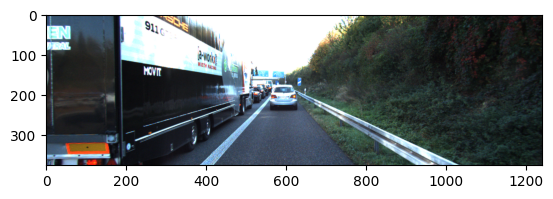

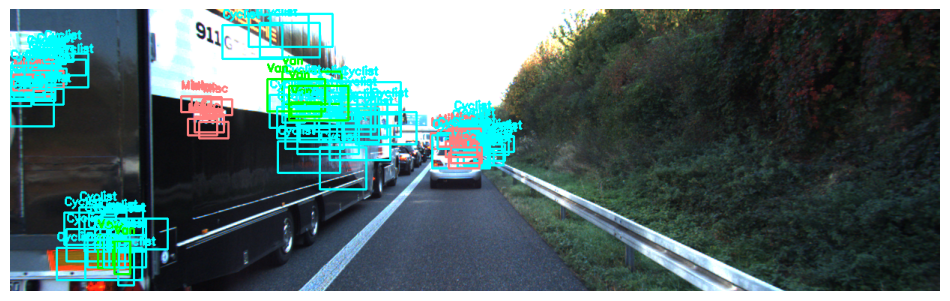

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_with_boxes(image, boxes, labels, label_names):
    # Convert tensor image to numpy array
    image = image.numpy().transpose((1, 2, 0))
    # Scale the image's pixel values to [0, 255]
    image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

    # Define colors for different classes
    colors = {
        'Car': (255, 0, 0), 'Van': (0, 255, 0), 'Truck': (0, 0, 255),
        'Pedestrian': (255, 255, 0), 'Person_sitting': (255, 0, 255), 'Cyclist': (0, 255, 255),
        'Tram': (127, 127, 255), 'Misc': (255, 127, 127), "Don'tCare": (127, 127, 127)
    }

    # Draw boxes and labels
    for box, label in zip(boxes, labels):
        box = box.numpy()
        label = int(label)
        box = box.astype(int)
        print(label)
        label_text = label_names[label]
        color = colors.get(label_text, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), color, 2)

        # Put label
        cv2.putText(image, label_text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define label names based on your dataset specifics
label_names = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', "Don'tCare"]

# Sample call to the function

target = predictions[0]
image = dataset[0][0]
plt.imshow(image.permute(1, 2, 0))
# This assumes `image` is a tensor from the dataset, `boxes` is a tensor of bounding boxes, and `labels` is a tensor of label indices
visualize_image_with_boxes(image, target['boxes'], target['labels'], label_names)
